In [37]:
from dysh.spectra.spectrum import Spectrum
import numpy as np
from scipy.stats import norm
import astropy.units as u
import matplotlib.pyplot as plt
from dysh.fits.sdfitsload import SDFITSLoad
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.spectra.scan import PSScan, GBTPSScan
import pandas
from copy import deepcopy
pandas.set_option('display.max_rows', 100)
from astropy.modeling.fitting import LevMarLSQFitter,LinearLSQFitter
from specutils import Spectrum1D, SpectrumList,SpectralRegion
from astropy.nddata import StdDevUncertainty
from specutils.fitting import fit_continuum
import matplotlib.pyplot as plt
from dysh.spectra import region_to_axis_indices
from dysh.plot.specplot import SpectrumPlot
from astropy.io import fits
from astropy.table import Table
import pandas as pd
#%matplotlib notebook

# 1. Create a gaussian spectrum with noise, compute the baseline, remove it, then add the baseline back in

### First, create the spectrum

In [38]:
npts = 1000
x = np.arange(npts)
restfreq = 110.20137*u.GHz
cdelt1=10*u.kHz
xfreq = restfreq+(x-npts//2)*cdelt1
y = 3.14+ np.random.rand(npts)+1000*norm(loc=npts/2,scale=50).pdf(x)
header={
'CDELT1': cdelt1.to('Hz').value, 
'CRVAL1': xfreq[0].to('Hz').value,
'CUNIT1': 'Hz',
'CTYPE1': 'FREQ', 'CRPIX1': 1, 'RESTFRQ': restfreq.value, 
'CTYPE2': 'RA--SIN', 'CRVAL2': 221.34, 'CRPIX2': 1,
'CTYPE3': 'DEC--SIN', 'CRVAL3': -12.13, 'CRPIX3': 1,
'CUNIT2': 'deg', 'CUNIT3':'deg',
'NAXIS1': len(x), 'NAXIS2':1, 'NAXIS3':1,
'OBJECT':"NGC 3421"
}

s = Spectrum(flux=y*u.K,spectral_axis=xfreq, rest_value = restfreq, meta=header,
             velocity_convention='radio',radial_velocity=25*u.Unit('km/s'))
s.velocity

<Quantity [38.60202954, 38.57482548, 38.54762142, 38.52041736, 38.4932133 ,
           38.46600924, 38.43880518, 38.41160113, 38.38439707, 38.35719301,
           38.32998895, 38.30278489, 38.27558083, 38.24837677, 38.22117271,
           38.19396865, 38.16676459, 38.13956053, 38.11235648, 38.08515242,
           38.05794836, 38.0307443 , 38.00354024, 37.97633618, 37.94913212,
           37.92192806, 37.894724  , 37.86751994, 37.84031589, 37.81311183,
           37.78590777, 37.75870371, 37.73149965, 37.70429559, 37.67709153,
           37.64988747, 37.62268341, 37.59547935, 37.56827529, 37.54107124,
           37.51386718, 37.48666312, 37.45945906, 37.432255  , 37.40505094,
           37.37784688, 37.35064282, 37.32343876, 37.2962347 , 37.26903064,
           37.24182659, 37.21462253, 37.18741847, 37.16021441, 37.13301035,
           37.10580629, 37.07860223, 37.05139817, 37.02419411, 36.99699005,
           36.96978599, 36.94258194, 36.91537788, 36.88817382, 36.86096976,
           3

In [39]:
s.write('/tmp/spec.fits',overwrite=True)
#hdu=fits.open('/tmp/spec.fits')
from astropy.nddata import CCDData
s.write.list_formats()
from specutils.io.registers import identify_spectrum_format
identify_spectrum_format('/tmp/spec.fits')

        Format         Read Write Auto-identify Deprecated
---------------------- ---- ----- ------------- ----------
           ascii.basic   No   Yes            No           
ascii.commented_header   No   Yes            No           
     ascii.fixed_width   No   Yes            No           
            ascii.ipac   No   Yes            No           
               votable   No   Yes            No           
                 basic   No   Yes            No        Yes
      commented_header   No   Yes            No        Yes
           fixed_width   No   Yes            No        Yes
                  ipac   No   Yes            No        Yes


'tabular-fits'

In [40]:
s.uncertainty=StdDevUncertainty(np.random.rand(npts))

In [41]:
s.write('/tmp/spec.txt',format='ipac',overwrite=True)

### Plot it with SpectrumPlot

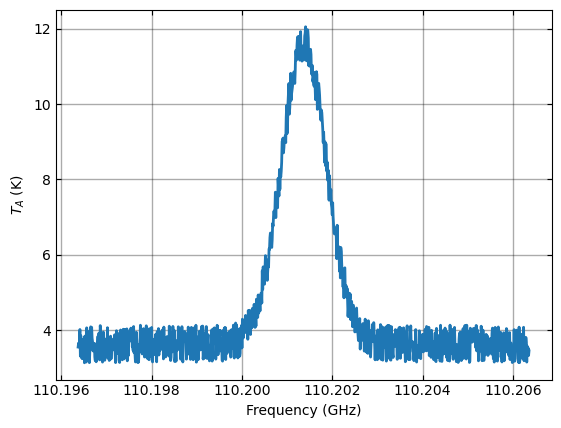

In [42]:
p = SpectrumPlot(s)
p.plot(grid=True)

In [43]:
if False:  # testing how to indicate baseline exclude region with a line under the x axis
    p.plot(color='green',grid=True,xaxis_unit="channel",clip_on=False)
    #p.axis.set_clip_on(False)
    xr = p.axis.get_xlim()
    yr = p.axis.get_xlim()
    transx = p.axis.get_xaxis_transform()
    transy = p.axis.get_yaxis_transform()
    p.axis.plot(xr,[-0.02,-0.02], color="orange", transform=transx, clip_on=False,lw=1.2)
    #p.axis.axhline(y=2,color='orange')

### Note plot attributes are sticky, e.g. the grid stays on until you turn it off
Is this a good feature?  Would be useful for a standalone plot that stays up between plot updates.

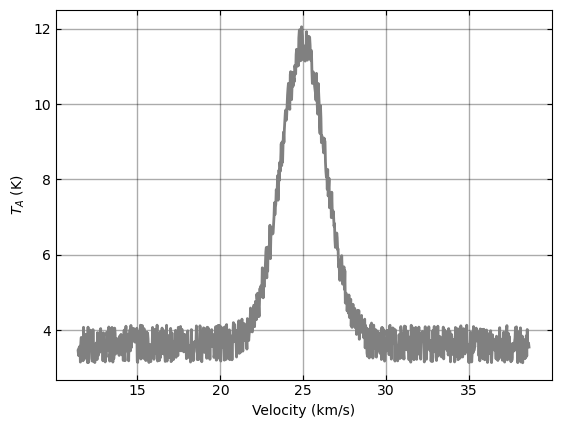

In [44]:
p.plot(color='gray',xaxis_unit="km/s")

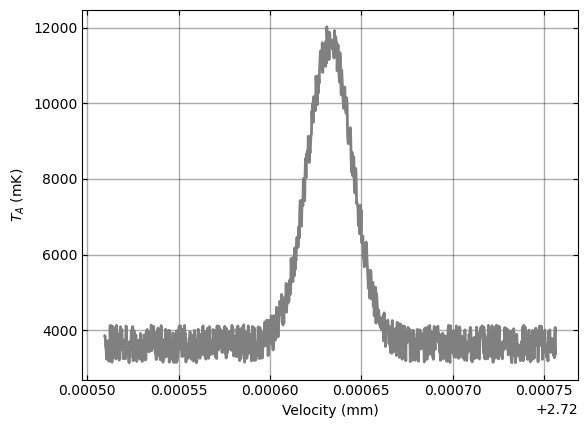

In [13]:
p.plot(xaxis_unit="mm",yaxis_unit="mK")
# Haha it should say wavelength not velocity

### Reset arguments to defaults

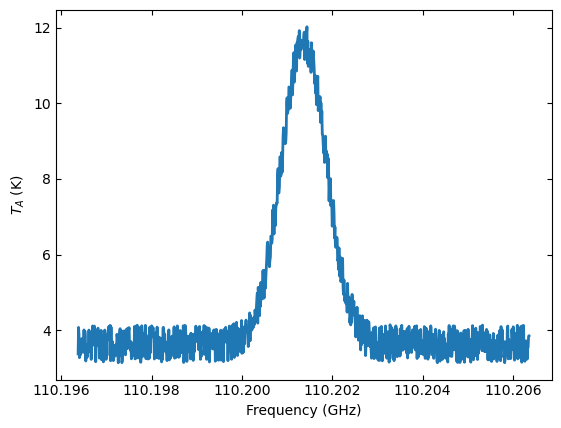

In [14]:
p.reset()
p.plot()

### You can also plot directly from the Spectrum

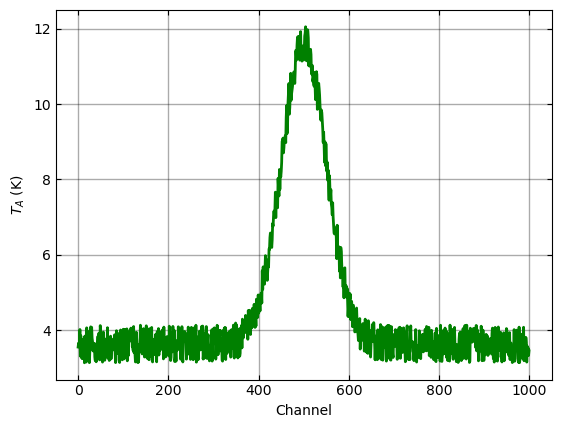

In [45]:
s.plot(color='green',grid=True,xaxis_unit="channel")

----------------------

## Baseline subtraction


### Use channels for the exclude region. Compute the baseline, exclude channels 300 to 700, don't remove it.
The red line shows the computed baseline
Note that since exclude_action is not set, the exclude region attribute on the spectrum itself will not be set.
Attempting to show baseline exlcusion range with orange line.  Seems shifted -- is it radial_velocity?

EXCLUDING [Spectral Region, 1 sub-regions:
  (110.19937 GHz, 110.20336999999999 GHz) 
]


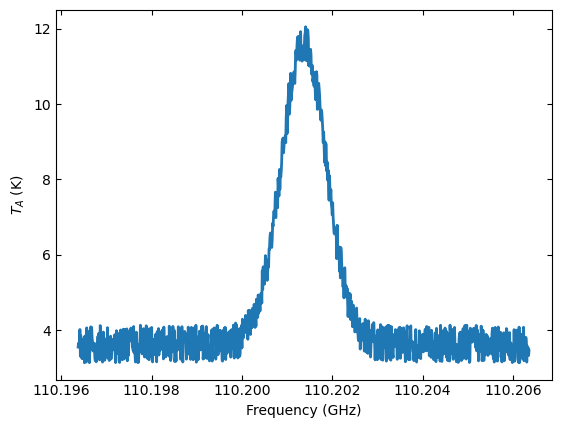

[Spectral Region, 1 sub-regions:
  (110.19937 GHz, 110.20336999999999 GHz) 
]
[300 700]
baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                 c1        
            K               K / GHz      
    ------------------ ------------------
    153.85911535653187 -1.363330710471203
XLIM  (110.1958705, 110.20685950000001)
(110.19637, 110.19937)
(110.20336999999999, 110.20636)


In [51]:
s._plotter=None
s._undo_baseline()
s.baseline(1,exclude=[300,700],remove=False)#,exclude_action='replace')
s.plot()
print(s.exclude_regions)
idx = region_to_axis_indices(s.exclude_regions[0],s)
print(idx)
s.bshow()
s.plotter.axis.plot(s.spectral_axis,s._baseline_model(s.spectral_axis),color='r')
transx = s.plotter.axis.get_xaxis_transform()
xr1 =(s.spectral_axis[0].value,s.spectral_axis[idx[0]].value)
print("XLIM ",s.plotter.axis.get_xlim())
print(xr1)
xr2 =(s.spectral_axis[idx[1]].value,s.spectral_axis[-1].value)
print(xr2)
s.plotter.axis.plot(xr1,[-0.02,-0.02], color="orange", transform=transx, clip_on=False,lw=1.2)
s.plotter.axis.plot(xr2,[-0.02,-0.02], color="orange", transform=transx, clip_on=False,lw=1.2)
#ax.plot(s.spectral_axis,s._baseline_model(s.exclude_regions),color='g')
#ax.axvline(x=110.201,ymin=0,ymax=12,color='k',lw=4)
s.plotter._plt.show()

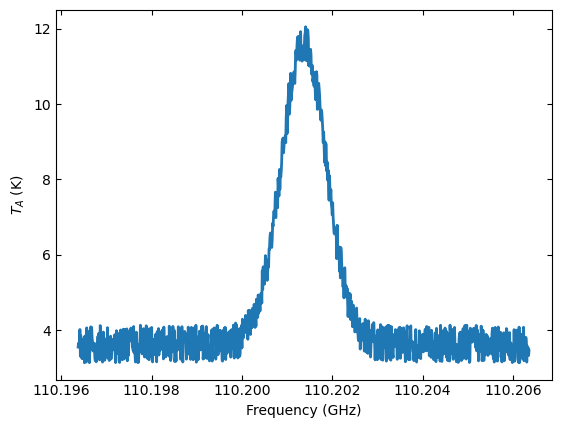

In [50]:
s._undo_baseline()
s.plot()

## test using exclude outside spectral axis
first should warn, second should except


In [17]:
s.baseline(1,exclude=[300,6700],remove=False,fix_exclude=True)
s.baseline(1,exclude=[300,6700],remove=False)

/home/mpound/src/dysh/src/dysh/spectra/core.py:117: UserWarning: Exclude limits [300, 6700] are not fully within the spectral axis [0,999]. Setting upper limit to 999.
  warnings.warn(msg)


EXCLUDING [Spectral Region, 1 sub-regions:
  (110.19937 GHz, 110.20636 GHz) ]


Exception: Exclude limits [300, 6700] are not fully within the spectral axis [0,999].

## Use a frequency Quantity for the exclude region
Try presetting a spectral exclude region and replace it or not.

EXCLUDING [Spectral Region, 1 sub-regions:
  (110.199 GHz, 110.2037 GHz) ]
baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 0
Parameters:
            c0        
            K         
    ------------------
    3.6355875799183988
EXCLUDING [Spectral Region, 1 sub-regions:
  (110.198 GHz, 110.204 GHz) ]


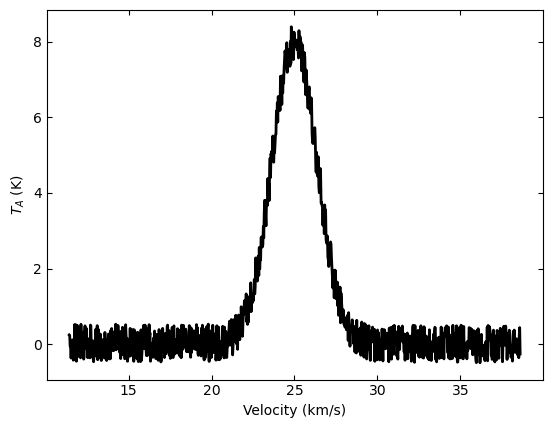

baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                 c1        
            K               K / GHz      
    ----------------- -------------------
    347.3668005250084 -3.1192369191603118


In [18]:
s._exclude_regions = [SpectralRegion(110.199*u.GHz,110.2037*u.GHz)]
s.baseline(degree=0,remove=False)
s.bshow()
s.baseline(degree=1,remove=True,exclude=[110.198*u.GHz,110.204*u.GHz],exclude_action='replace')
s.plot(color='black',xaxis_unit="km/s")
s.bshow()
# haha should say "Velocity"

In [19]:
# this should except
s.baseline(1,exclude=[110.199*u.GHz,210.2037*u.GHz],remove=False)

Exception: Exclude limits [<Quantity 110.199 GHz>, <Quantity 210.2037 GHz>] are not fully within the spectral axis [<SpectralAxis 
   (observer to target:
      radial_velocity=25.0 km / s
      redshift=8.339450112093694e-05
    doppler_rest=110.20137 GHz
    doppler_convention=radio)
  110.19637 GHz>, <SpectralAxis 
   (observer to target:
      radial_velocity=25.0 km / s
      redshift=8.339450112093694e-05
    doppler_rest=110.20137 GHz
    doppler_convention=radio)
  110.20636 GHz>].

EXCLUDING [Spectral Region, 1 sub-regions:
  (110.19937000434334 GHz, 110.20337000006775 GHz) 
]


 [astropy.modeling.fitting]


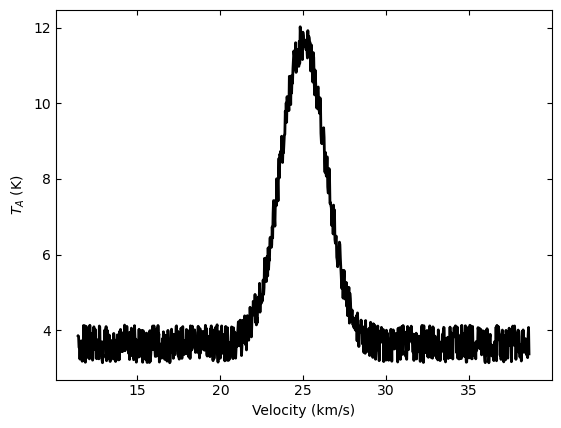

In [20]:
s._undo_baseline()
kms = u.Unit("km/s")
s.baseline(2,exclude=[19.559188*kms,30.4408*kms],remove=False)
s.plot()
s.plotter.axis.plot(s.spectral_axis,s._baseline_model(s.spectral_axis),color='r')

### print some statistics [mean, rms, min, max], show the baseline model function

In [21]:
print(s.stats())
s.bshow()

(<Quantity 4.63466233 K>, 2.17432177858797, <Quantity 3.14057118 K>, <Quantity 12.02119912 K>)
baseline model Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                 c1                    c2          
            K               K / GHz               K / GHz2       
    ------------------ ------------------ -----------------------
    435.43974603526937 -3.917596642776686 -5.8547308717199525e-06


### now do again it and remove the baseline

In [22]:
### undo the baseline removal.  Stats shows it has been added back in and the spectrum is restored

In [23]:
s._undo_baseline()
print(s.stats())
s.bshow()


(<Quantity 8.27880896 K>, 2.174412249234142, <Quantity 6.7686767 K>, <Quantity 15.66505184 K>)
baseline model None


In [24]:
from dysh.fits.gbtfitsload import GBTFITSLoad
# Assuming you are in the dysh root dir.
sdf_file = "/home/mpound/src/dysh/src/dysh/fits/tests/data/TGBT21A_501_11_ifnum_0_int_0-2.fits"
sdf = GBTFITSLoad(sdf_file)
psscan = sdf.getps(152, plnum=0)
psscan.calibrate()
psscan.tsys
#>>> array([17.17140405, 17.3474724 , 17.0515161 ])
# The above should be:
#>>> array([17.24000345, 17.17140405, 17.15663698])

PSSCAN nrows = 6


array([17.24000331, 17.17140407, 17.15663706])

In [25]:
datadir = '/data/gbt'
#f = datadir + '/examples/misc/ngc5291.fits'
f = datadir + '/examples/onoff-L/data/TGBT21A_501_11.raw.vegas.fits'
#f = datadir + 'examples/nod-KFPA/data/TGBT22A_503_02.raw.vegas/TGBT22A_503_02.raw.vegas.A.fits'
#f = datadir + '/examples/mixed-fs-ps/data/AGBT16B_225_05/AGBT16B_225_05.raw.vegas/AGBT16B_225_05.raw.vegas.A.fits'
p = GBTFITSLoad(f)

In [26]:
psscan = p.getps(152, plnum=0)
psscan.calibrate()
psscan.tsys

PSSCAN nrows = 302


array([17.24000331, 17.17140407, 17.15663706, 16.85934938, 17.35722808,
       17.13173533, 17.21543758, 17.30092209, 17.00566634, 16.96166486,
       16.90800341, 17.25126361, 16.95204999, 17.07164599, 17.31209217,
       17.24198662, 17.23042937, 17.23062697, 17.2208193 , 17.16465836,
       17.1068358 , 17.06225729, 17.00860451, 16.95643358, 16.86738642,
       17.2413057 , 17.23751996, 17.08227417, 17.39648624, 17.25251859,
       17.07859784, 17.0780406 , 17.1786181 , 17.24824256, 17.24999314,
       16.90474545, 16.96177053, 17.00971644, 17.08732091, 17.01572004,
       17.18919809, 17.007733  , 17.2285048 , 17.12418593, 17.33777034,
       16.96650494, 17.35763204, 17.11744121, 17.39144286, 17.39013935,
       17.05786049, 17.19779676, 17.23384302, 17.30106535, 17.30310275,
       17.24598303, 17.07625013, 16.90833126, 17.10750069, 17.27291884,
       17.28189002, 16.98815592, 17.00188419, 17.13296967, 17.07062651,
       17.27226935, 17.3023025 , 17.07989051, 16.89637028, 17.10

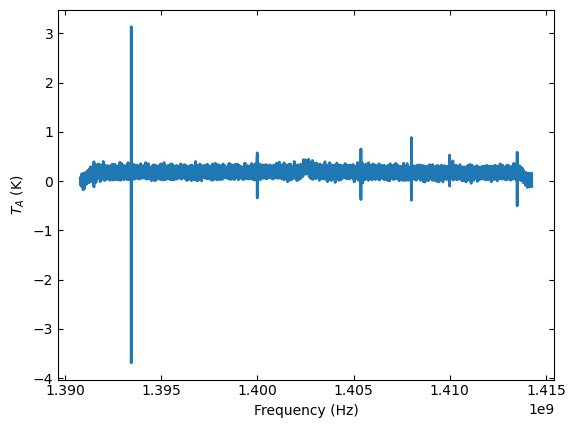

In [28]:
spec=psscan.timeaverage()
spec.plot()